# Plots

In [61]:
%matplotlib inline

In [186]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

## Load the Timings

For each class of machine, load the data.

In [296]:
basedir = '../outputs/parallel_timings/hyperthreading'
vectors = ['addiction', 'age', 'foi', 'mcsims', 'years']

In [297]:
timings = {
    k: {
        j: {}
        for j in ('stochastic', 'deterministic')
    }
    for k in vectors
}

for pwd, dirs, files in os.walk(basedir):
    csv_files = [f for f in files if os.path.splitext(f.lower())[-1] == '.csv']
    if len(csv_files) < 1:
        continue
    cores = int(os.path.basename(pwd).split('-')[0])
    for f in csv_files:
        df = pd.read_csv(os.path.join(pwd, f))
        sd, vector = os.path.splitext(f)[0].split('_')
        timings[vector][sd][cores] = df

Now, load the single-core versions.

In [298]:
basedir = '../outputs/timings'

In [299]:
for pwd, dirs, files in os.walk(basedir):
    csv_files = [f for f in files if os.path.splitext(f.lower())[-1] == '.csv']
    if len(csv_files) < 1:
        continue
    for f in csv_files:
        df = pd.read_csv(os.path.join(pwd, f))
        sd, vector = os.path.splitext(f)[0].split('_')
        timings[vector][sd][1] = df

## Plots for Each Vector

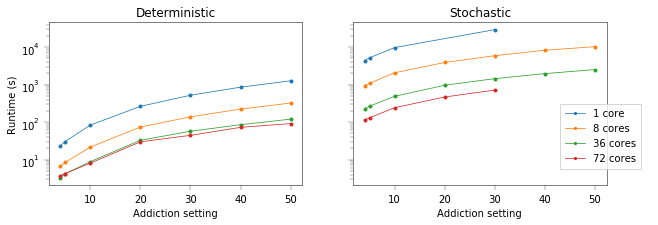

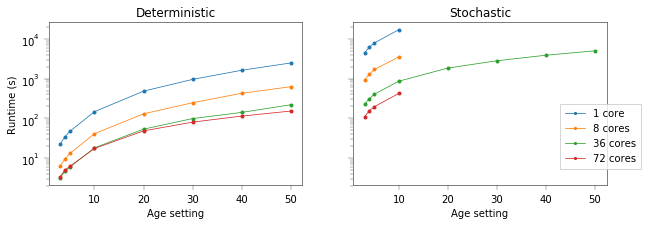

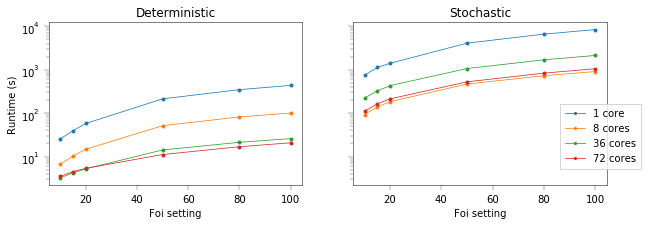

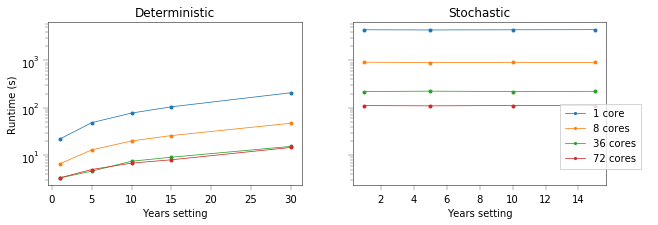

In [300]:
for vector in vectors:
    # Skip mcsims
    if vector == 'mcsims':
        continue
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
    for i, sd in enumerate(('deterministic', 'stochastic')):
        for n in sorted(timings[vector][sd]):
            df = timings[vector][sd][n]
            # Fix years
            if vector == 'years':
                df = df[df.iloc[:,0] <= 30]
            
            # Label
            label = ''
            if i == 1:
                label = f'{n} core' + ('s' if n != 1 else '')
            
            # Plot
            axes[i].plot(df.iloc[:,0], df.iloc[:,1], '-o', label=label)
        
        # Axes
        if i == 0:
            axes[i].set_ylabel('Runtime (s)')
        axes[i].set_yscale('log')
        axes[i].set_title(sd.capitalize())
        axes[i].set_xlabel(vector.capitalize() + ' setting')
    fig.legend(loc=(0.85, 0.25))

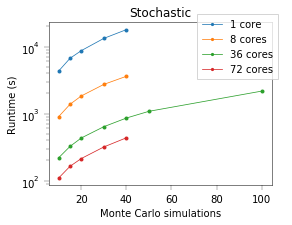

In [304]:
# Now mcsims -- stochastic only
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for n in sorted(timings['mcsims']['stochastic']):
    df = timings['mcsims']['stochastic'][n]
    ax.plot(df.iloc[:,0], df.iloc[:,1], '-o', label=(f'{n} core' + ('s' if n != 1 else '')))
# Axes
ax.set_ylabel('Runtime (s)')
ax.set_yscale('log')
ax.set_title(sd.capitalize())
ax.set_xlabel('Monte Carlo simulations')
fig.legend()#loc=(0.85, 0.25))

## Scaling for Reference Models

I ran the default models and saved the output logs, so they need to be scraped for the timings. The files are named accoring to the formula `modeltype_awscores_awsprocs_coresused.txt`.

In [305]:
basedir = '../outputs/parallel_timings/hyperthreading/reference'
ref_timings = {k: {} for k in ('det', 'sto')}
timing_files = filter(lambda f: f.lower().endswith('.txt'), os.listdir(basedir))
for file in timing_files:
    with open(os.path.join(basedir, file), 'r') as f:
        runtime = float(re.search(r'([0-9.]+)\s+seconds', f.read()).group(1))
        kind, _, _, cores = os.path.splitext(file)[0].split('_')
        cores = int(cores)
        ref_timings[kind][cores] = runtime

In [317]:
# Don't include N-1 timings
ref = {j: np.array(sorted([[k, ref_timings[j][k]] for k in ref_timings[j]])) for j in ref_timings}

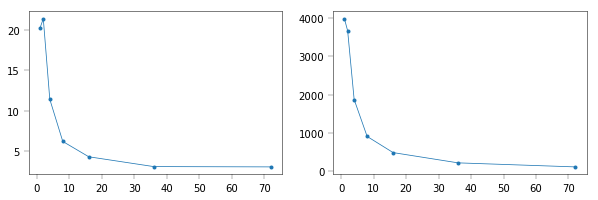

In [319]:
fig, [axl, axr] = plt.subplots(1, 2, figsize=(10, 3))
axl.plot(ref['det'][:,0], ref['det'][:,1], '-o')
axr.plot(ref['sto'][:,0], ref['sto'][:,1], '-o')

**TO DO**

- get 4 core tests
- get 8-core re-tests
- get 16 core re-tests
- get 36 core re-tests
- re-run years for 4, 8, 16, 36, and 72 [72 IP]
- do computations